# Фінальне завдання
## Завантаження датасету **Breast Cancer**

In [707]:
from sklearn.datasets import load_breast_cancer

# Завантаження набору даних
data = load_breast_cancer()

# Ознаки
X = data.data

# Цільова змінна (0 - злоякісна, 1 - доброякісна)
y = data.target

## Розділяємо дані на тренувальні та тестові

In [708]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


## Декларуємо утилітарні функції
### Функція виводу розподілу фічі за таргетом
**Таргетом** тут буде дані, чи пухлина є злоякісною (1), чи доброякісною (0). Саме це і стане кластерами в майбутньому дослідженні.

In [709]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

def show_data_distribution_by_target(df: pd.DataFrame, y, fields: list | None = None):
    # Валідації
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df має бути pandas.DataFrame")
    if len(df) != len(y):
        raise ValueError(f"Довжина df ({len(df)}) не збігається з довжиною y ({len(y)})")

    df_work = df.copy()

    if fields is not None:
        fields = list(fields)
        cols = set(df_work.columns)
        missing = [c for c in fields if c not in cols]
        if missing:
            # Жорстка поведінка: чітка помилка зі списком відсутніх
            raise KeyError(f"Відсутні колонки у df: {missing}. Доступні колонки: {list(df_work.columns)}")
            # М’яка альтернатива (розкоментуйте замість raise):
            # present = [c for c in fields if c in cols]
            # if not present:
            #     raise KeyError(f"Жодної з полів {fields} не знайдено у df")
            # fields = present

        df_work = df_work[fields]

    # Додаємо ціль як окрему колонку в копії
    df_work = df_work.assign(target=pd.Series(y, index=df_work.index))

    # Далі — ваш існуючий аналіз/візуалізації.
    # Приклад (закоментовано, бо коду немає):
    sns.pairplot(df_work, hue="target")
    plt.show()

### Функція показу **Confusion Matrix**

In [710]:
def show_confusion_matrix(y_true, y_pred, labels=(0, 1), cmap="Blues"):
    """
    Відображає НОРМАЛІЗОВАНУ confusion matrix (по рядках, normalize='true')
    з підписами TN, FP, FN, TP на відповідних клітинках і значеннями-долями.
    """
    # Нормалізація по істинних класах (рядках)
    cm = confusion_matrix(y_true, y_pred, labels=list(labels), normalize="true")

    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        cm, annot=False, fmt=".2f", cmap=cmap, cbar=True,
        vmin=0.0, vmax=1.0,
        xticklabels=labels, yticklabels=labels, ax=ax
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion matrix (normalized=true)")

    # Відповідність клітинок:
    # (0,0) -> TN, (0,1) -> FP, (1,0) -> FN, (1,1) -> TP
    tags = np.array([["TN", "FP"], ["FN", "TP"]])

    for i in range(2):
        for j in range(2):
            ax.text(
                j + 0.5, i + 0.5,
                f"{tags[i, j]}\n{cm[i, j]:.2f}",
                ha="center", va="center",
                color="black", fontsize=11, fontweight="bold"
            )

    plt.tight_layout()
    plt.show()

### Перетворення даних, отриманих функцією *load_breast_cancer()* у *pandas.DataFrame*

In [711]:
def ensure_dataframe(X, feature_names=None):
    if isinstance(X, pd.DataFrame):
        return X
    # створюємо імена колонок, якщо не передані
    if feature_names is None:
        try:
            n_features = X.shape[1]
        except Exception:
            # якщо X одномірний, перетворимо у 2D
            X = X.reshape(-1, 1)
            n_features = 1
        feature_names = [f"f{i}" for i in range(n_features)]
    return pd.DataFrame(X, columns=feature_names)

### Функція оптимізації та кластеризації за методом **PCA**

In [712]:
from sklearn.preprocessing import StandardScaler


def perform_optimization_and_clustering_with_pca(x):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(x)

    pca = PCA(n_components=3, random_state=42)  # або n_components=0.95 для збереження 95% дисперсії
    return pca.fit_transform(X_scaled)

### Функція корекції міток кластерів після кластеризації методами *sklearn*
Дана операція викликана тим, що бінарна кластеризація функціями *sklearn* часто кластеризує в кластер *0*, тоді, як оригінальний кластер був *1*.

In [713]:
def align_cluster_labels(y_true, y_pred):
    # Підладка міток кластерів під target (бінарний випадок)
    acc = accuracy_score(y_true, y_pred)
    if acc < 0.5:
        return 1 - y_pred
    return y_pred

### Функція кластеризації з ланцюжком **Kmeans -> GaussianMixture** без стандартизації

In [714]:
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture

def perform_complex_clustering_without_scaling(X_train, n_clusters=2, random_state=42):
    """
    Повертає sklearn Pipeline: Kmeans -> GaussianMixture.
    """
    pipe = Pipeline(steps=[
        ("k_mean", KMeans(n_clusters=n_clusters, random_state=random_state)),
        ("gmm", GaussianMixture(n_components=n_clusters, random_state=random_state))
    ])
    pipe.fit(X_train)
    return pipe

### Функція кластеризації з ланцюжком **Kmeans -> GaussianMixture** з попереньою стандартизацією даних

In [715]:
def perform_complex_clustering_with_scaling(X_train, n_clusters=2, random_state=42):
    """
    Повертає sklearn Pipeline: KMeans -> GaussianMixture.
    """
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("k_mean", KMeans(n_clusters=n_clusters, random_state=random_state)),
        ("gmm", GaussianMixture(n_components=n_clusters, random_state=random_state))
    ])
    pipe.fit(X_train)
    return pipe

### Функція логістичної регресії без оптимізації параметрів

In [716]:
def perform_complex_clustering_with_logistic_regression(X_train, y_train, n_components_pca=3, random_state=42):
    """
    Повертає sklearn Pipeline: PCA -> LogisticRegression.
    """
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components_pca, random_state=random_state)),
        ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
    ])
    pipe.fit(X_train, y_train)
    return pipe

### Функція логістичної регресії з параметризації параметрів з допомогою градієнтного спуску

In [717]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV


def perform_complex_clustering_with_logistic_regression_with_gradient_desc(X_train, y_train, n_components_pca=3, random_state=42):
    pipe = perform_complex_clustering_with_logistic_regression(X_train, y_train, n_components_pca=n_components_pca, random_state=random_state)
    param_grid = [
    {
        "clf__solver": ["lbfgs"],
        "clf__penalty": ["l2"],
        "clf__C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
        "clf__tol": [1e-4, 1e-5],
    },
    {
        "clf__solver": ["saga"],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [1e-3, 1e-2, 1e-1, 1, 10, 100],
        "clf__tol": [1e-4, 1e-5],
        "clf__l1_ratio": [None],  # або додайте окрему сітку для elasticnet
    },
    {
        "clf__solver": ["saga"],
        "clf__penalty": ["elasticnet"],
        "clf__l1_ratio": [0.1, 0.5, 0.9],
        "clf__C": [1e-3, 1e-2, 1e-1, 1, 10],
        "clf__tol": [1e-4, 1e-5],
    },
]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    gs = GridSearchCV(pipe, param_grid, scoring="f1", cv=cv, n_jobs=-1, refit=True)
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_
    return best_model

### Функція логістичної регресії з оптимізацією параметрів з допомогою генетичного алгоритму

In [718]:
import numpy as np
from pygad import pygad
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def perform_complex_clustering_with_logistic_regression_with_gen_alg(X_train, y_train, n_components_pca=5, random_state=42):
    rng = np.random.default_rng(random_state)

    # Гени хромосоми (модель параметризується генами у векторі довжини 4):
    # [0] n_clusters  -> кількість кластерів для KMeans (цілочисельно)
    # [1] C           -> коефіцієнт регуляризації LogisticRegression (float > 0)
    # [2] max_iter    -> максимальна кількість ітерацій для LogisticRegression (цілочисельно)
    # [3] solver_id   -> індекс солвера LogisticRegression зі списку solvers (цілочисельно)
    solvers = ["lbfgs", "liblinear", "saga", "newton-cg"]
    num_genes = 4

    def create_population(sol_per_pop=8):
        # Ініціалізація початкової популяції рішень випадковими гіперпараметрами
        pop = []
        for _ in range(sol_per_pop):
            # n_clusters у [2, 7], C у [1e-2, 1e2], max_iter у [100, 599], solver_id у [0, len(solvers)-1]
            n_clusters = int(rng.integers(2, 8))
            C = float(10 ** rng.uniform(-2, 2))
            max_iter = int(rng.integers(100, 600))
            solver_id = int(rng.integers(0, len(solvers)))
            pop.append([n_clusters, C, max_iter, solver_id])
        return pop

    def decode_solution(solution):
        # Декодування генів у валідні гіперпараметри з обмеженнями
        n_clusters = int(round(solution[0]))
        n_clusters = max(2, min(20, n_clusters))  # обмежуємо діапазон кластерів
        C = float(solution[1])
        C = max(1e-4, min(1e3, C))  # обмежуємо регуляризацію
        max_iter = int(round(solution[2]))
        max_iter = max(50, min(5000, max_iter))  # обмежуємо ітерації
        solver_id = int(round(solution[3]))
        solver_id = max(0, min(len(solvers) - 1, solver_id))
        solver = solvers[solver_id]
        return n_clusters, C, max_iter, solver

    # Крок 1: Зменшення розмірності ознак PCA для стабільнішого кластеризаційно-класифікаційного пайплайну
    pca = PCA(n_components=n_components_pca, random_state=random_state)
    X_tr_pca = pca.fit_transform(X_train)

    def fitness_func(ga_instance, solution, solution_idx):
        # Оцінка придатності (fitness) індивіда:
        # 1) Декодуємо гени у гіперпараметри
        n_clusters, C, max_iter, solver = decode_solution(solution)

        # 2) Кластеризація KMeans на PCA-просторі
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
        clusters = kmeans.fit_predict(X_tr_pca)

        # 3) Формуємо розширені ознаки: [PCA-компоненти, метка_кластера]
        X_feat = np.column_stack([X_tr_pca, clusters])
        try:
            # 4) Навчання LogisticRegression на розширених ознаках
            lr = LogisticRegression(C=C, max_iter=max_iter, solver=solver)
            lr.fit(X_feat, y_train)

            # 5) Точність на тренуванні як функція якості (fitness)
            y_pred = lr.predict(X_feat)
            return accuracy_score(y_train, y_pred)
        except Exception:
            # Якщо комбінація гіперпараметрів невалідна для обраного solver/penalty тощо — штрафуємо 0
            return 0.0

    def bounded_mutation(offspring, ga_instance):
        # Мутація із збереженням коректних меж кожного гену
        for i in range(offspring.shape[0]):
            gene_idx = rng.integers(0, num_genes)
            if gene_idx == 0:
                # Зсув n_clusters на {-2..+2}, з кліпінгом у [2, 20]
                offspring[i, gene_idx] += rng.integers(-2, 3)
                offspring[i, gene_idx] = np.clip(offspring[i, gene_idx], 2, 20)
            elif gene_idx == 1:
                # Мутація C у лог-шкалі для стабільності (крок приблизно 10^±0.5)
                logC = np.log10(max(1e-4, float(offspring[i, gene_idx])))
                logC += rng.uniform(-0.5, 0.5)
                offspring[i, gene_idx] = 10 ** np.clip(logC, -4, 3)
            elif gene_idx == 2:
                # Зміна max_iter у межах ±100, з кліпінгом у [50, 5000]
                offspring[i, gene_idx] += rng.integers(-100, 101)
                offspring[i, gene_idx] = np.clip(offspring[i, gene_idx], 50, 5000)
            else:
                # solver_id як цілочисельний ген у [0, len(solvers)-1]
                step = rng.integers(-1, 2)  # -1, 0, 1
                new_id = int(round(offspring[i, gene_idx])) + step
                new_id = max(0, min(len(solvers) - 1, new_id))
                offspring[i, gene_idx] = new_id
        return offspring

    # Крок 2: Налаштування та запуск генетичного алгоритму
    ga = pygad.GA(
        num_generations=500,  # кількість поколінь
        num_parents_mating=4,  # скільки батьків беруть участь у схрещуванні
        sol_per_pop=8,  # розмір популяції
        num_genes=num_genes,  # кількість генів в індивіді
        fitness_func=fitness_func,  # функція придатності
        initial_population=create_population(),  # початкова популяція
        mutation_type=bounded_mutation,  # користувацька мутація з обмеженнями
        suppress_warnings=True
    )

    ga.run()  # еволюція популяції
    solution, fitness, _ = ga.best_solution()  # найкращий індивід та його fitness
    n_clusters, C, max_iter, solver = decode_solution(solution)

    # Крок 3: Фінальне донавчання моделей на всіх тренувальних даних з найкращими гіперпараметрами
    kmeans_final = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    X_tr_pca = pca.fit_transform(X_train)  # повторно підганяємо PCA на тренуванні
    clusters_tr = kmeans_final.fit_predict(X_tr_pca)  # отримуємо кластери
    X_feat_tr = np.column_stack([X_tr_pca, clusters_tr])  # формуємо фінальні ознаки

    lr_final = LogisticRegression(C=C, max_iter=max_iter, solver=solver)
    lr_final.fit(X_feat_tr, y_train)

    # Крок 4: Повертаємо просту пайплайн-модель з методом predict
    class PipelineModel:
        def __init__(self, pca, kmeans, lr):
            self.pca = pca
            self.kmeans = kmeans
            self.lr = lr

        def predict(self, X):
            # Трансформації у тій самій послідовності: PCA -> KMeans -> конкатенація -> LR
            Xp = self.pca.transform(X)
            cl = self.kmeans.predict(Xp)
            Xf = np.column_stack([Xp, cl])
            return self.lr.predict(Xf)

    return PipelineModel(pca, kmeans_final, lr_final)


### Утилітарні функції виводу балів точності моделі

In [719]:
from sklearn.metrics import f1_score, accuracy_score

def get_f1_score(y_true, y_predict):
    return f1_score(y_true, y_predict, average='binary', pos_label=1)

def get_accuracy_score(y_true, y_predict):
    return accuracy_score(y_true, y_predict)

## Проводимо дослідження
### Перетворимо наші тестові та тренувальні дані на датафрейми

In [720]:
df_train = ensure_dataframe(X_train, data.feature_names)

df_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
1,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
2,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
3,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
4,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994


In [721]:
df_test = ensure_dataframe(X_test, data.feature_names)

df_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,10.32,16.35,65.31,324.9,0.09434,0.04994,0.01012,0.005495,0.1885,0.06201,...,11.25,21.77,71.12,384.9,0.1285,0.08842,0.04384,0.02381,0.2681,0.07399
1,20.18,19.54,133.80,1250.0,0.11330,0.14890,0.21330,0.125900,0.1724,0.06053,...,22.03,25.07,146.00,1479.0,0.1665,0.29420,0.53080,0.21730,0.3032,0.08075
2,10.66,15.15,67.49,349.6,0.08792,0.04302,0.00000,0.000000,0.1928,0.05975,...,11.54,19.20,73.20,408.3,0.1076,0.06791,0.00000,0.00000,0.2710,0.06164
3,13.56,13.90,88.59,561.3,0.10510,0.11920,0.07860,0.044510,0.1962,0.06303,...,14.98,17.13,101.10,686.6,0.1376,0.26980,0.25770,0.09090,0.3065,0.08177
4,11.37,18.89,72.17,396.0,0.08713,0.05008,0.02399,0.021730,0.2013,0.05955,...,12.36,26.14,79.29,459.3,0.1118,0.09708,0.07529,0.06203,0.3267,0.06994


### Виводимо розподіл ознак за кластерами
У нашому випадку кластерами буде **злоякісна пухлина (1)** і **доброякісна пухлина (0)**. Оскільки ознак у нас багато та їх повна візуалізація несумісна з людськими можливостями, ми виведемо кластеризацію перших 4 ознак. Як тут, так і в подальших візуалізаціях.

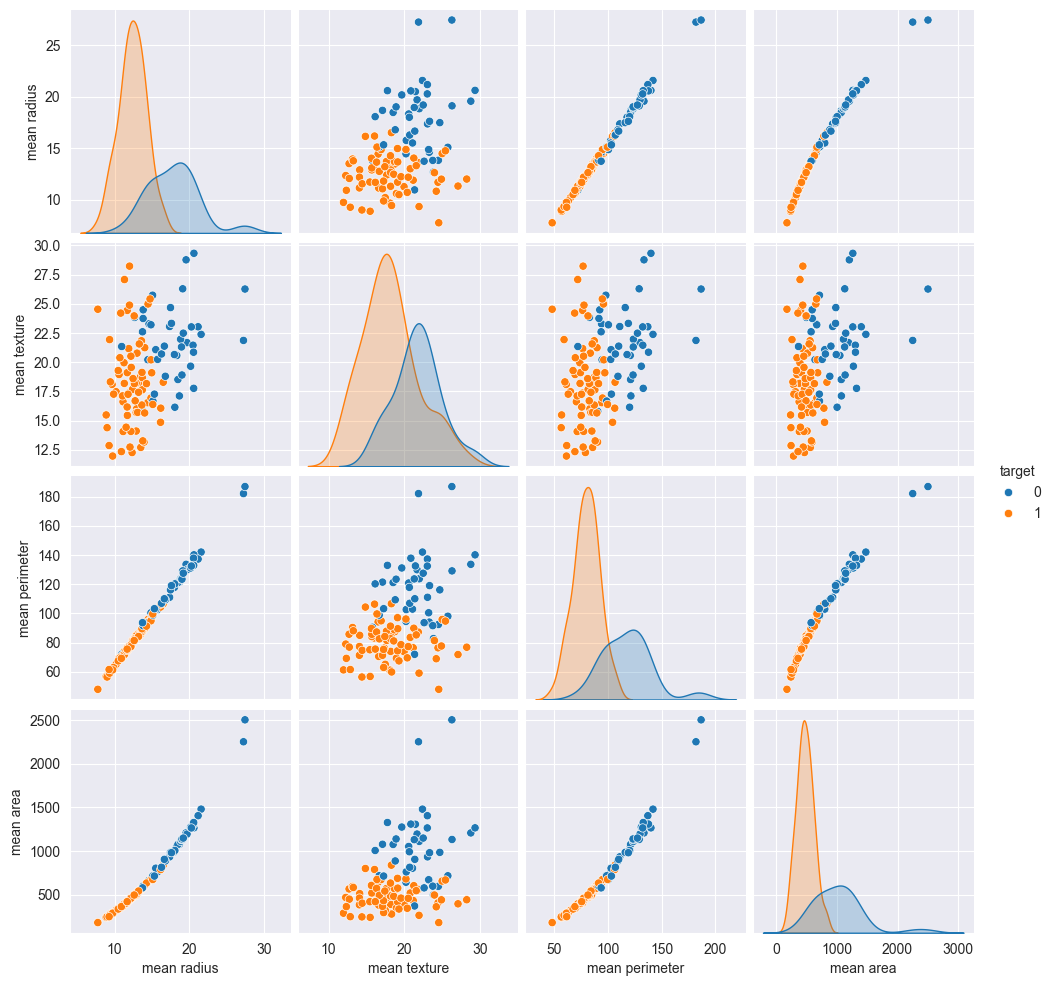

In [722]:
show_data_distribution_by_target(df_test, y_test, ['mean radius', 'mean texture', 'mean perimeter', 'mean area'])

### Кластеризація ланцюжком K Means та Гаусовими сумішами без стандартизації даних та оптимізації параметрів

/Users/kozak_mamay/PycharmProjects/WoolfDataScience/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


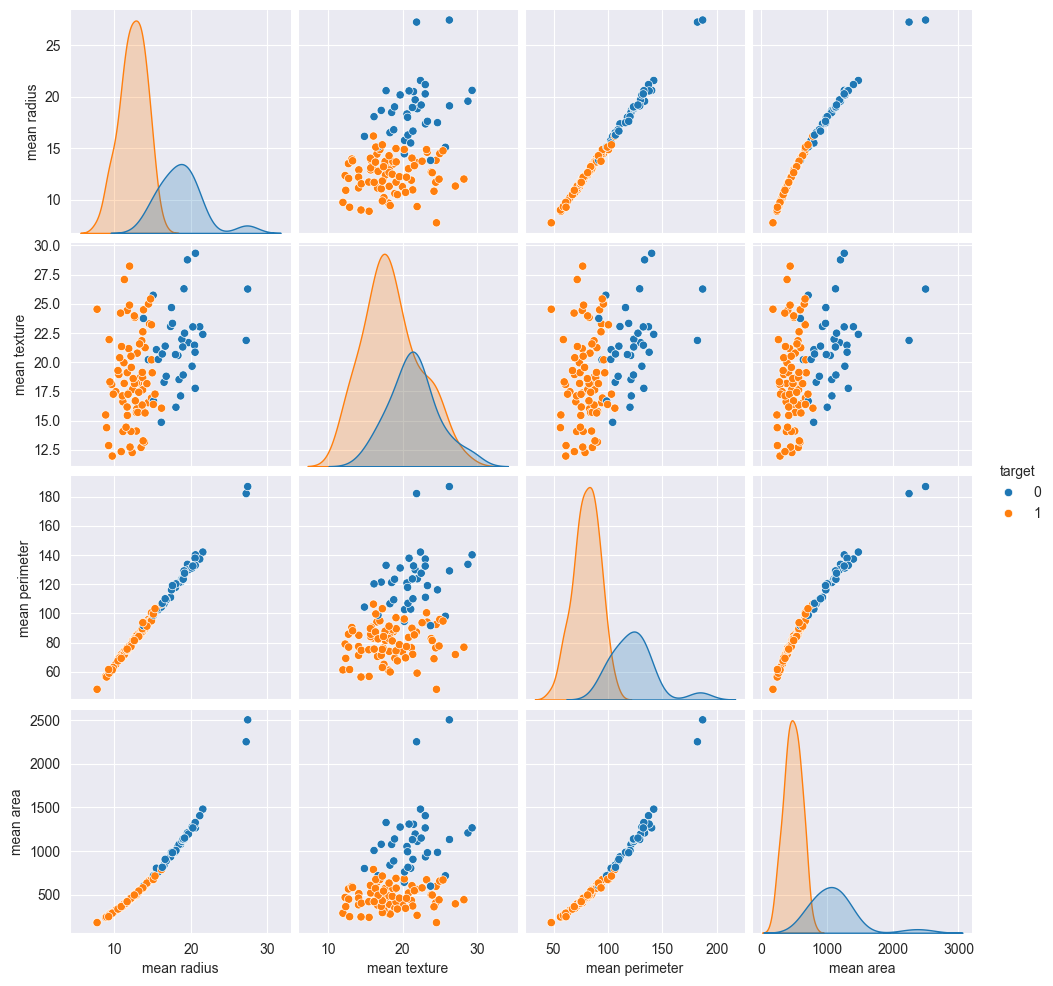

In [723]:
y_predict = perform_complex_clustering_without_scaling(X_train).predict(df_test)
y_predict = align_cluster_labels(y_test, y_predict)
show_data_distribution_by_target(df_test, y_predict, ['mean radius', 'mean texture', 'mean perimeter', 'mean area'])

In [724]:
print("Показник точності f1: ", get_f1_score(y_test, y_predict))
print("Показник точності accuracy score: ", get_accuracy_score(y_test, y_predict))

Показник точності f1:  0.9333333333333333
Показник точності accuracy score:  0.9122807017543859


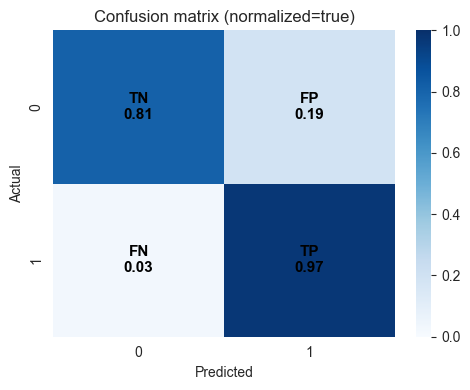

In [725]:
show_confusion_matrix(y_test, y_predict)

Модель дає доволі непогану точність (більше 90%). Але **Confusion Matrix** показує велику кіькість хибно позитивних прогнозів (аж 19%). Тобто при вживанні такої моделі дуже багато пацієнтів будуть проходити непотрібні процедури та аналізи, оскільки матимуть хибні діагнози. Маємо і 3% хибно негативних прогнозів, що взагалі нестиме загрозу життю.

###  Кластеризація ланцюжком K Means та Гаусовими сумішами із стандартизацією даних та без оптимізації параметрів

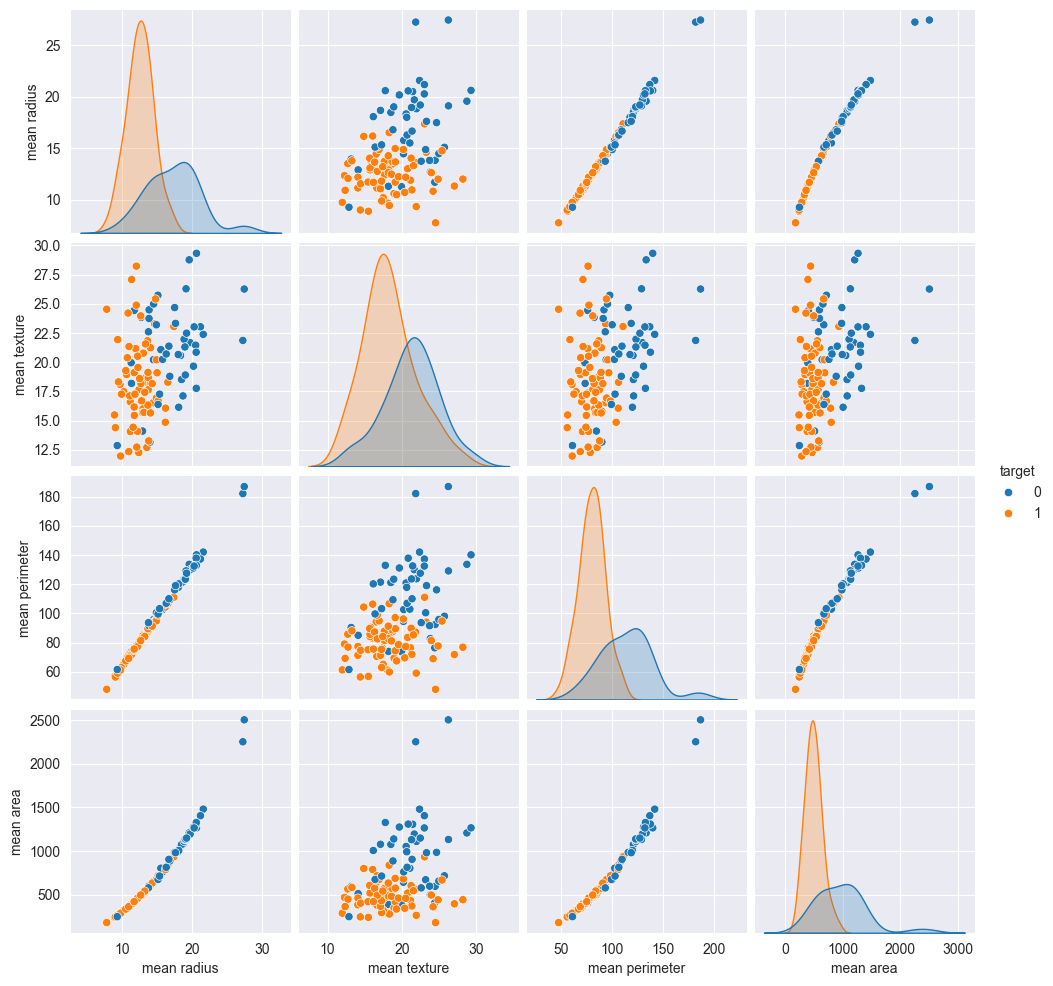

In [726]:
y_scaled_predict = perform_complex_clustering_with_scaling(X_train).predict(X_test)
y_scaled_predict = align_cluster_labels(y_test, y_scaled_predict)
show_data_distribution_by_target(df_test, y_scaled_predict, ['mean radius', 'mean texture', 'mean perimeter', 'mean area'])

In [727]:
print("Показник точності f1: ", get_f1_score(y_test, y_scaled_predict))
print("Показник точності accuracy score: ", get_accuracy_score(y_test, y_scaled_predict))

Показник точності f1:  0.9078014184397163
Показник точності accuracy score:  0.8859649122807017


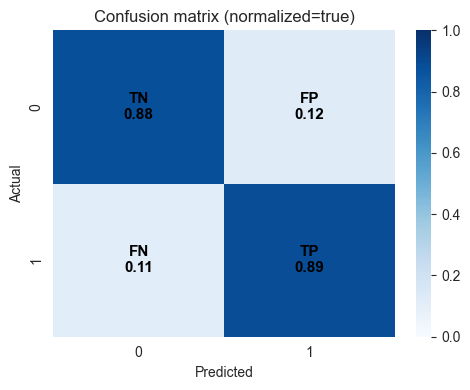

In [728]:
show_confusion_matrix(y_test, y_scaled_predict)

Як бачимо, стандартизація даних у нашому випадку значно погіршило модель. Адже тепер ми маємо як 12% хибно позитивних прогнозів, так і 11% хибно негативних прогнозів. Передчасна оптимізація часом віддаляє від вирішення задачі, аніж наближає.

### Кластеризуємо методом **PCA** та виводимо новий розподіл

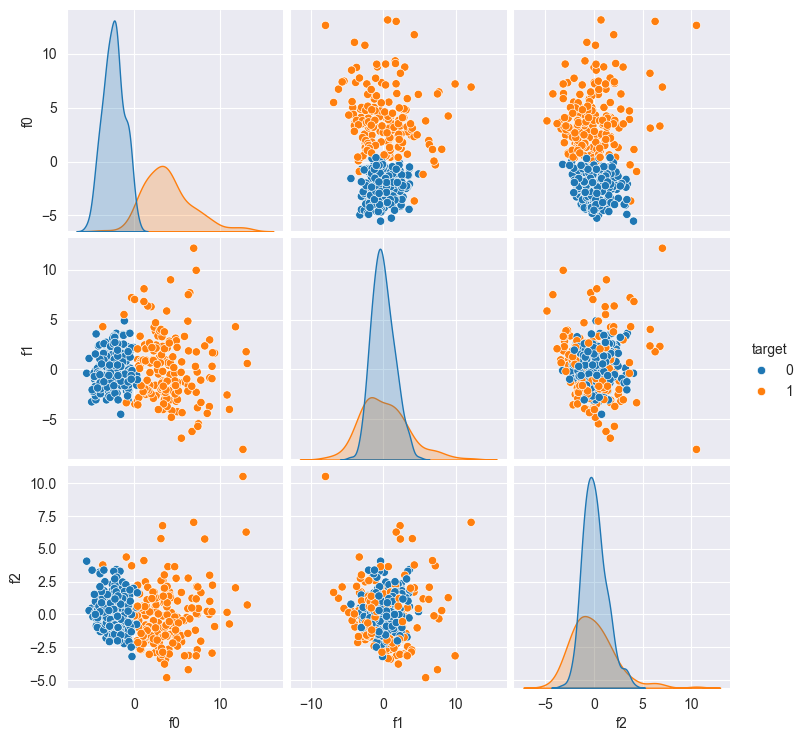

In [729]:
X_pca = perform_optimization_and_clustering_with_pca(X_train)

df_pca = ensure_dataframe(X_pca)

y_pca_clustered = perform_complex_clustering_without_scaling(X_pca).predict(X_pca)

show_data_distribution_by_target(df_pca, y_pca_clustered)

Бачимо, що після зменшення розмірності по всіх ознаках ми спостерігаємо нормальний розподіл Гауса-Лапласа. Нптомість у більшості нових ознак бачимо змішання точок з різних кластерів, що робить кластеризацію складнішою.

### Кластеризація простим методом логістичної регресії

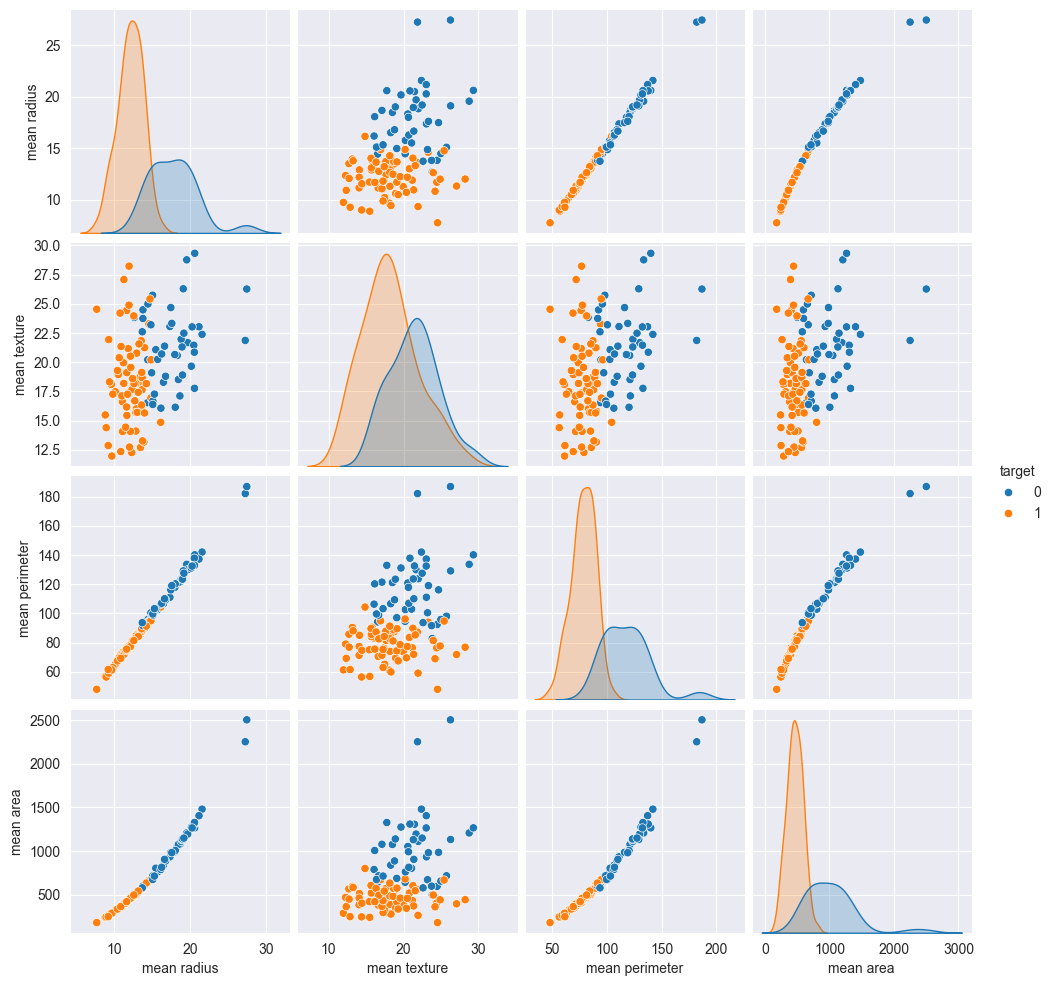

In [730]:
y_log_reg = perform_complex_clustering_with_logistic_regression(X_train, y_train).predict(X_test)
y_log_reg = align_cluster_labels(y_test, y_log_reg)
show_data_distribution_by_target(df_test, y_log_reg, ['mean radius', 'mean texture', 'mean perimeter', 'mean area'])

In [731]:
print("Показник точності f1: ", get_f1_score(y_test, y_log_reg))
print("Показник точності accuracy score: ", get_accuracy_score(y_test, y_log_reg))

Показник точності f1:  0.9361702127659575
Показник точності accuracy score:  0.9210526315789473


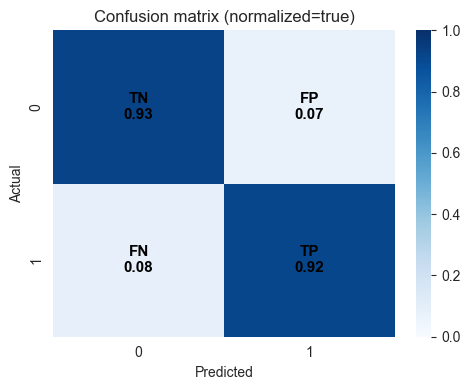

In [732]:
show_confusion_matrix(y_test, y_log_reg)

Бачимо, що у нашому випадку використання методу логістичної регресії значно покращує модель навіть в порівнянні з простим **K Mean** з **Гаусовими сумішами**. Хибно позитивні прогнози зменшились до 7%, але, натомість відсоток хибно негативних прогнозів збільшилось із 3% до 8%. Тобто, попри в загальному більшу точність прогнозування, використання цієї моделі несе більшу загрозу життю пацієнта. Власне, напевно ця модель гірша з точки зору бізнес логіки.

### Логістична регресія з оптимізацією параметрів градієнтним спуском

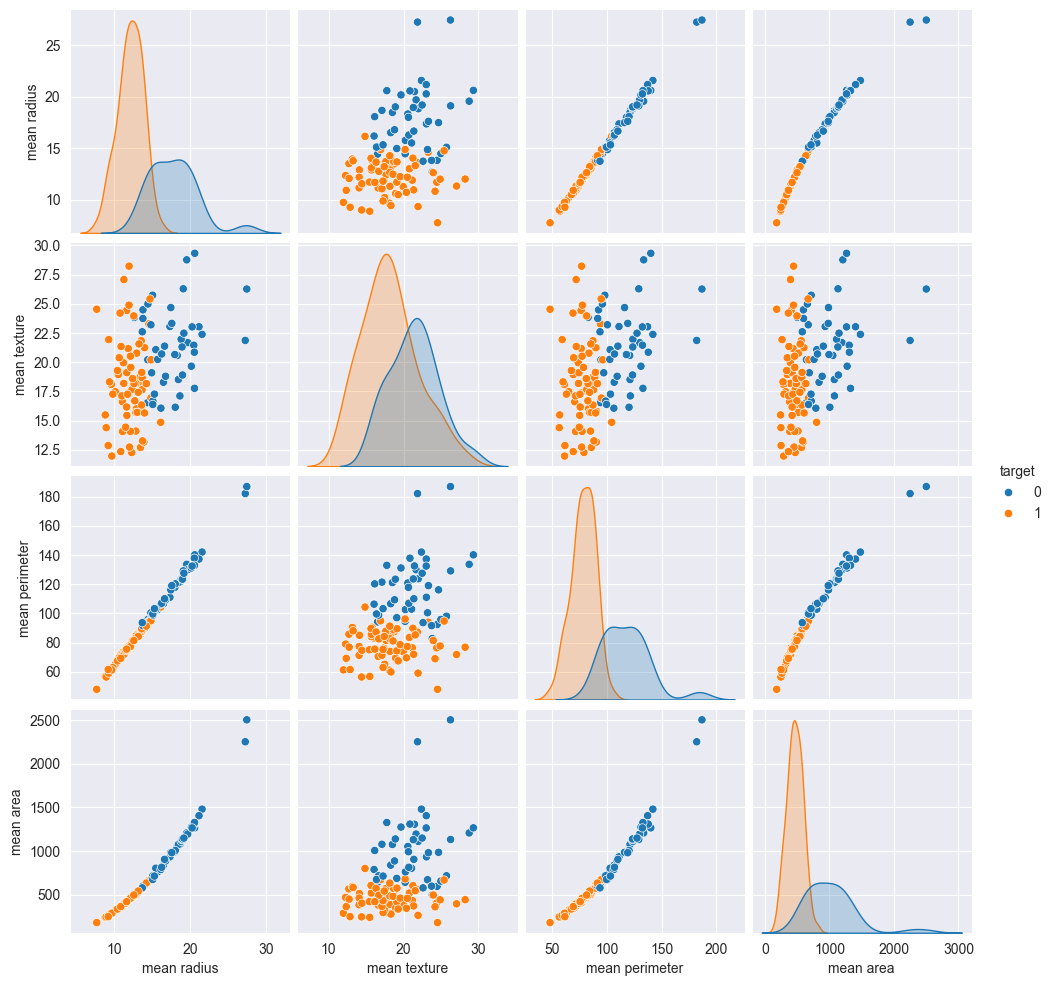

In [733]:
y_log_reg_drag_asc = perform_complex_clustering_with_logistic_regression_with_gradient_desc(X_train, y_train).predict(X_test)
y_log_reg_drag_asc = align_cluster_labels(y_test, y_log_reg_drag_asc)
show_data_distribution_by_target(df_test, y_log_reg_drag_asc, ['mean radius', 'mean texture', 'mean perimeter', 'mean area'])

In [734]:
print("Показник точності f1: ", get_f1_score(y_test, y_log_reg_drag_asc))
print("Показник точності accuracy score: ", get_accuracy_score(y_test, y_log_reg_drag_asc))

Показник точності f1:  0.9361702127659575
Показник точності accuracy score:  0.9210526315789473


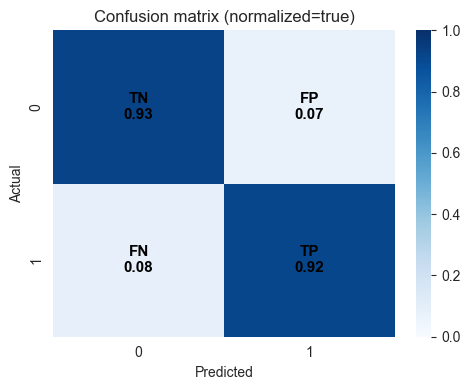

In [735]:
show_confusion_matrix(y_test, y_log_reg_drag_asc)

Як бачимо, наша реалізація градієнтного спуску в принципі не змінило попередню модель.

### Логістична регресія з оптимізацією параметрів за методом генетичного алгоритму

/Users/kozak_mamay/PycharmProjects/WoolfDataScience/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kozak_mamay/PycharmProjects/WoolfDataScience/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kozak_mamay/PycharmProjects/WoolfDataScience/.venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/kozak_mamay/PycharmProjects/WoolfDataScience/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 50 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=50).
You migh

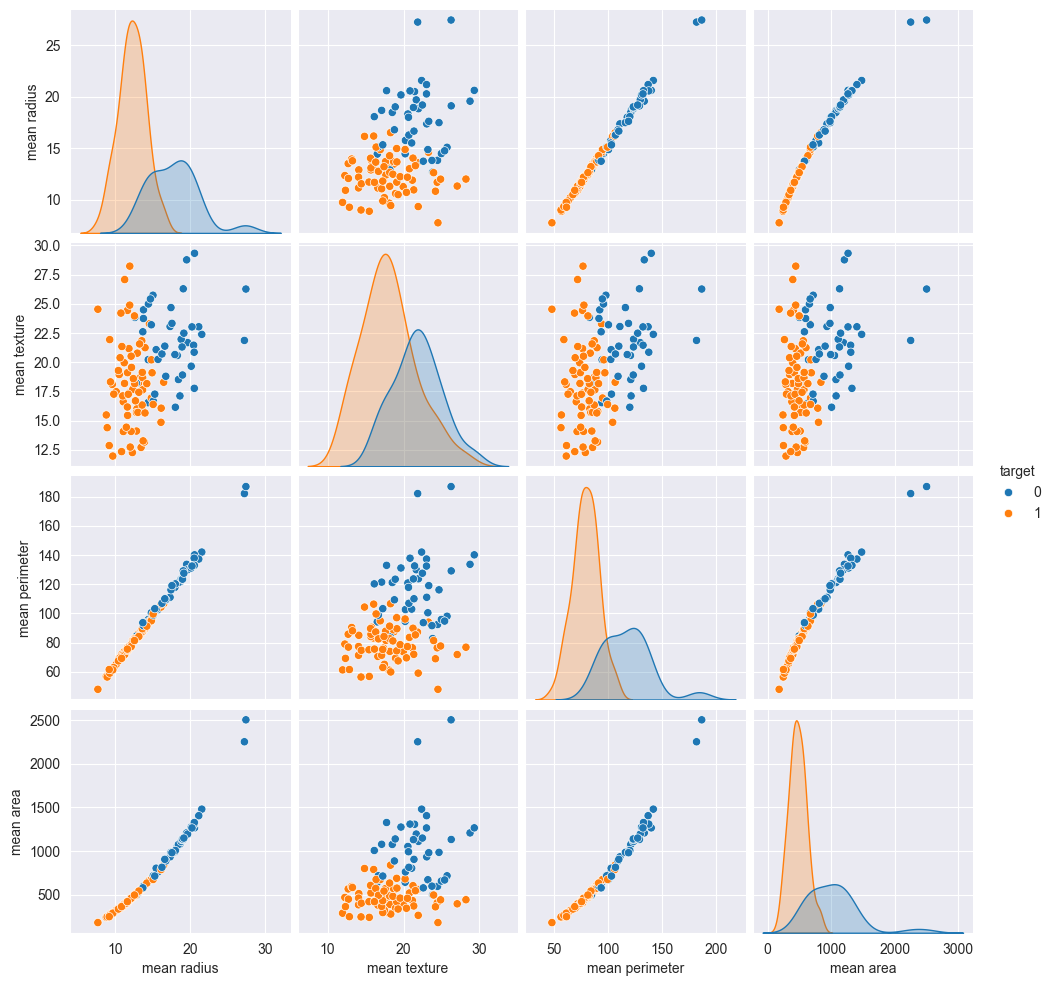

In [736]:
y_log_reg_gen = perform_complex_clustering_with_logistic_regression_with_gen_alg(X_train, y_train).predict(X_test)
y_log_reg_gen = align_cluster_labels(y_test, y_log_reg_gen)
show_data_distribution_by_target(df_test, y_log_reg_gen, ['mean radius', 'mean texture', 'mean perimeter', 'mean area'])

In [737]:
print("Показник точності f1: ", get_f1_score(y_test, y_log_reg_gen))
print("Показник точності accuracy score: ", get_accuracy_score(y_test, y_log_reg_gen))

Показник точності f1:  0.951048951048951
Показник точності accuracy score:  0.9385964912280702


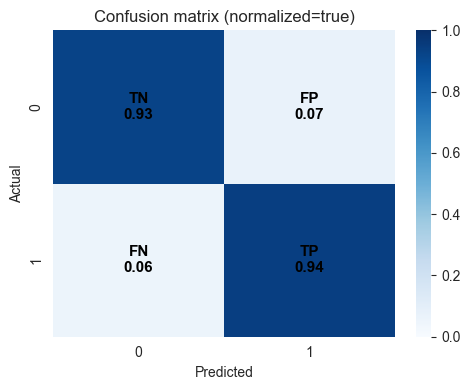

In [738]:
show_confusion_matrix(y_test, y_log_reg_gen)

Як бачимо, генетичний алгоритм значно покращив якість логістичної регресії, адже відсоток хибно позитивних прогнозів зменшився з 8% до 6%, що значно краще з точки зору бізнес вимог.

## Висновки
Наше дослідження показало 2 найкращі моделі:
1. **Логістична регресія з оптимізацією параметрів методом генетичного алгоритму**
2. **Кластеризація ланцюжком K Means та Гаусовими сумішами без стандартизації даних та оптимізації параметрів**

Перша модель найкраща технічно, адже у неї найменший відсоток хибних прогнозів. З іншого боку, друга модель все ж прийнятніша з бізнес точки зору, адже у неї менший відсоток хибно негативних прогнозів, хоч і хибно позитивних - значно більше, аніж в першій. Але менший відсоток хибно негативних прогнозів дозволяє врятувати більше життів, аніж перша. Тобто, я більше схильний обрати кластеризацію **ланцюжком K Means та Гаусовими сумішами без стандартизації даних та оптимізації параметрів** з наведених тут.